In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# check what files in the pubmed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [6]:
 # Preprocess data
 # create a function to read lines of the document
def get_lines(filename):
  """

  Reads filename and return the lines of text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# read in training files
train_lines  = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
# How should the data look
def preprocess_text_with_line_numbers(filename):
  """

  Returns a list of dictionaries of abstractt line data

  Takes in filename, reads its contents and sorts through each line, 
  extrating things like target label, text of the sentence,
  and how many sentences are in the current abstract and what sentence number
  target line is.
  """

  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstact
  abstract_samples = [] # create an empty list of abstracts

  # Loop throught each line in target file
  for line in input_lines:
    if line.startswith('###'): #check to see if its an ID line
      abstract_id = line
      abstract_lines = " " # reset the abstract string if the line id an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split tatrget label form text
        line_data['target'] = target_text_split[0] # get target text and lower it
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number #  what number does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? 
        abstract_samples.append(line_data)

    else: # if the abvoe condition aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples   

In [10]:
# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 529 ms, sys: 122 ms, total: 651 ms
Wall time: 655 ms


In [11]:
# check the first abstract from the training data
train_samples[:20]

[{'line_number': 0,
  'target': ' OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures includ

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(24)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels
train_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)
val_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)
test_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

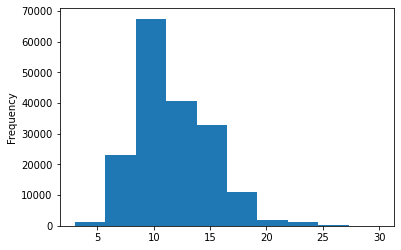

In [14]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

In [15]:
# convert abstract text lines into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [17]:
# Make numeric labels
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))


# check what it looks like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
# Extract labels and encode them into intergers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
## Model 0: Getting a baseline with Multinomial Naive Bayes

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ('tf-idf', TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make some prediction with the bsaeline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
from helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [24]:
## Preparing the text data for deep sequence model
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# How long is the sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

In [26]:
max(sent_lens), min(sent_lens)

(296, 1)

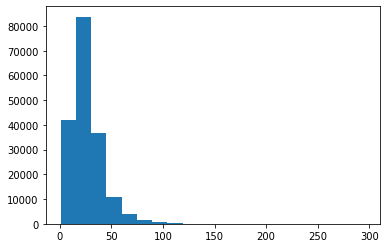

In [27]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [28]:
# How long of a sentence length covers 95% of the examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
# Create text vectorizer layer (turn word to numbers)
# How many word are in the vocabulary (68K for 20K dataset)
max_tokens = 68000

# Create a text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = 55) # desired output of length of vectorized sequences

In [30]:
# Adapt text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

In [31]:
# Test out text vectorizer on random sentence

import random
target_sentence = random.choice(train_sentences)
print(f'Text: \n {target_sentence}')
print(f'\n Length of text: {len(target_sentence)}')
print(f'\n Vectorized text: {text_vectorizer([target_sentence])}')

Text: 
 serum chemistry and @-hour urine samples collected at the end of each phase were compared using mixed model repeated measures analysis .

 Length of text: 136

 Vectorized text: [[  225 11705     3   629   943   513   444    15     2   199     4   122
    209     9    34    59   832   314   818   213    85     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
# How many words are in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocab: {len(rct_20k_text_vocab)}')
print(f'Most comoon words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in the vocab: 64841
Most comoon words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
# Create custom text embedding ( this captures the relationship between the vectrized words)

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocab
                               output_dim = 128, 
                               mask_zero = True, # to handle variable sequence lengths
                               name='token_embedding')


In [34]:
# show an example of embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding): \n {vectorized_sentence} \n')
embedding_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedding_sentence}\n')
print(f'Embedding entence shape: {embedding_sentence.shape}')

Sentence before vectorization:
 serum chemistry and @-hour urine samples collected at the end of each phase were compared using mixed model repeated measures analysis .

Sentence after vectorization (before embedding): 
 [[  225 11705     3   629   943   513   444    15     2   199     4   122
    209     9    34    59   832   314   818   213    85     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]] 

Sentence after embedding:
 [[[-0.02539829  0.04519304  0.0321944  ...  0.00311426  0.0225379
    0.00929811]
  [-0.01580957 -0.04756469  0.02675178 ... -0.04608746  0.01297827
   -0.04676522]
  [-0.00811261 -0.02041518 -0.00392745 ... -0.0020938  -0.04588633
   -0.04624107]
  ...
  [-0.00854305 -0.03240905 -0.01661186 ... -0.03462194 -0.00075411
    0.02999942]
  [-0.00854305 -0.03240905 -0.01661186 ... -0.03462194 -0.00075411
    

In [35]:
# Creating datasets (making the data load as fast aspossible)
# Turn data into tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [36]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [37]:
# Take tensorSliceDataset and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [38]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [39]:
# Model 2: Conv1D with token embeddings
# Create 1D conv model to process sequences

inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of out feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)


# Compile model
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [41]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [42]:
len(train_dataset)

5627

In [43]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) 

Epoch 1/3
562/562 [==============================] - 60s 105ms/step - loss: 0.9166 - accuracy: 0.6387 - val_loss: 0.6863 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 58s 103ms/step - loss: 0.6616 - accuracy: 0.7542 - val_loss: 0.6397 - val_accuracy: 0.7670
Epoch 3/3
562/562 [==============================] - 58s 104ms/step - loss: 0.6242 - accuracy: 0.7717 - val_loss: 0.6029 - val_accuracy: 0.7859


In [44]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.6057 - accuracy: 0.7844


[0.605743408203125, 0.7843571901321411]

In [45]:
# Mak predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.1764092e-01, 1.8597089e-01, 9.1047965e-02, 2.8372386e-01,
         2.1616288e-02],
        [4.2688209e-01, 2.9852623e-01, 1.1830463e-02, 2.5486243e-01,
         7.8988029e-03],
        [1.3555361e-01, 6.5218653e-03, 1.8184179e-03, 8.5608369e-01,
         2.2483124e-05],
        ...,
        [3.5254739e-06, 9.1610255e-04, 6.8560388e-04, 3.6706460e-06,
         9.9839109e-01],
        [6.0499392e-02, 4.4629675e-01, 9.0612613e-02, 8.0734789e-02,
         3.2185650e-01],
        [1.9941443e-01, 6.4366472e-01, 3.0091627e-02, 5.8519267e-02,
         6.8309978e-02]], dtype=float32), (30212, 5))

In [46]:
# convert pred probs into classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [48]:
# calculate model 1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.43572090560042,
 'f1': 0.7820961801541378,
 'precision': 0.7812513969952096,
 'recall': 0.7843572090560043}

In [49]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [50]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
major disability was gross motor disability , cognitive or language delay , severe hearing loss , or blindness .

Sentence after embedding:
[-0.02785567  0.02705298  0.03415175 -0.00573184 -0.05678463  0.0417832
 -0.05032573 -0.06261189  0.00371409 -0.01693683  0.07081298  0.05474958
  0.05400752 -0.04768854  0.0304109  -0.06361759 -0.07104239  0.03465385
 -0.02764767 -0.00787725  0.07040631  0.02599202 -0.06422565  0.05822532
 -0.06866472 -0.0384873  -0.05276579 -0.03773088 -0.06699049  0.00928615] (truncated output)...

Length of sentence embedding:
512


In [51]:
# Building and fitting an NLP feature extraction model using 
# pretrained embeddings
# Define feature extraction model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) 
# tokenize text and create embedding of ache sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Can add more layers here if you want
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

In [52]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [53]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data= valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9181 - accuracy: 0.6491 - val_loss: 0.7970 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7715 - accuracy: 0.6996 - val_loss: 0.7583 - val_accuracy: 0.7008
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7574 - accuracy: 0.7091 - val_loss: 0.7437 - val_accuracy: 0.7108


In [54]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7459 - accuracy: 0.7113


[0.7459234595298767, 0.7112736701965332]

In [55]:
# Make predictions with thw feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.44022962, 0.3722696 , 0.00248035, 0.17730123, 0.00771918],
       [0.31037715, 0.53281826, 0.00380244, 0.14995329, 0.00304888],
       [0.21923964, 0.13660789, 0.01985945, 0.586549  , 0.03774402],
       ...,
       [0.00202587, 0.00593964, 0.06258129, 0.00093486, 0.92851835],
       [0.00425453, 0.04409203, 0.21378678, 0.00173231, 0.73613435],
       [0.14350492, 0.30248302, 0.47997084, 0.00730617, 0.06673497]],
      dtype=float32)

In [56]:
# Convert the predictions probabiliteis 
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [57]:
# Calculate results from TF Hub pretrained embeedings results on val dataser
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.12736660929431,
 'f1': 0.7083382676266218,
 'precision': 0.7117884013639837,
 'recall': 0.7112736660929432}

In [58]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [59]:
# Model 3: Conv1D with character embeddings
# Create a character level tokenizer
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character level sequence into character
split_chars(random_training_sentence)

'm a j o r   d i s a b i l i t y   w a s   g r o s s   m o t o r   d i s a b i l i t y   ,   c o g n i t i v e   o r   l a n g u a g e   d e l a y   ,   s e v e r e   h e a r i n g   l o s s   ,   o r   b l i n d n e s s   .'

In [60]:
# Split sequence level data into character level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
# Whats's the average character length?
char_lengths = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_lengths)
mean_char_length

149.3662574983337

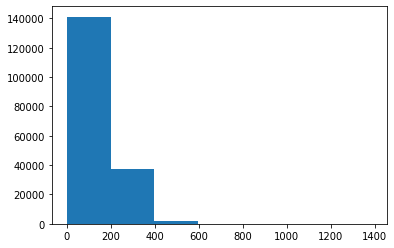

In [62]:
# Check the distribution of out sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lengths, bins=7);

In [63]:
# Find what characher length cover 95% of sequences
output_seq_char_len = int(np.percentile(char_lengths, 95))
output_seq_char_len

290

In [64]:
# Get all the keyboard characters
import string
alphabet = string.ascii_lowercase +string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
# create char level tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab tokrn)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize=None,
                                    name='char_vectorizer')

In [66]:
# adapt char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [67]:
# Check char vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different character in vocabulary: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least used characters: {char_vocab[-5:]}')

Number of different character in vocabulary: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least used characters: ['|', '"', ']', '\\', '[']


In [68]:
# Test out char vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text: \n {random_train_chars}')
print(f'Lengthof random_train_chars: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized text: \n {vectorized_chars}')
print(f'Length of vectorized chars: {len(vectorized_chars[0])}')

Charified text: 
 t h e   @ - y e a r   c f s   r a t e s   w e r e   @   %   m m c / m a i n t   ,   @   %   c i s p / m a i n t   ,   @   %   m m c / n o - m a i n t   a n d   @   %   c i s p / n o - m a i n t   .
Lengthof random_train_chars: 197
Vectorized text: 
 [[ 3 13  2 19 26 20  2  5  8 11 17  9  8  5  3  2  9 21  2  8  2 19 31 15
  15 11 35 15  5  4  6  3 24 19 31 11  4  9 14 35 15  5  4  6  3 24 19 31
  15 15 11 35  6  7 26 15  5  4  6  3  5  6 10 19 31 11  4  9 14 35  6  7
  26 15  5  4  6  3 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [69]:
# Create char embed layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different chars
                              output_dim = 25, # This is the size of char embedding in the paper
                              mask_zero = True,
                              name = 'char_embed')

In [70]:
# Test out char embed layer
print(f' Chars text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f' Embedded chars (after vectorization and embedding):\n {char_embed_example}')
print(f'Char embed shape: {char_embed_example.shape}')

 Chars text:
 t h e   @ - y e a r   c f s   r a t e s   w e r e   @   %   m m c / m a i n t   ,   @   %   c i s p / m a i n t   ,   @   %   m m c / n o - m a i n t   a n d   @   %   c i s p / n o - m a i n t   .

 Embedded chars (after vectorization and embedding):
 [[[-0.00135943 -0.00605857  0.0451547  ...  0.00065442 -0.00163536
   -0.0023121 ]
  [-0.00208635 -0.0032415   0.00807922 ... -0.00666621 -0.00888211
   -0.00397002]
  [ 0.04537263 -0.03585398  0.00566286 ...  0.02328566 -0.0396266
    0.02939952]
  ...
  [-0.01772896 -0.01392027 -0.0099079  ... -0.02378457  0.0418126
    0.04946262]
  [-0.01772896 -0.01392027 -0.0099079  ... -0.02378457  0.0418126
    0.04946262]
  [-0.01772896 -0.01392027 -0.0099079  ... -0.02378457  0.0418126
    0.04946262]]]
Char embed shape: (1, 290, 25)


In [71]:
# Building a Conv1D model to fit the character embeddings
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                          outputs=outputs,
                          name = 'model_2_char_embed')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

In [72]:
model_3.summary()

Model: "model_2_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)          

In [73]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,
                                                        train_labels_one_hot
                                                         )).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,
                                                        val_labels_one_hot
                                                         )).batch(32).prefetch(tf.data.AUTOTUNE)    

test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,
                                                        test_labels_one_hot
                                                         )).batch(32).prefetch(tf.data.AUTOTUNE)                                                                                                          

In [74]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [75]:
# Fit model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 31ms/step - loss: 1.1764 - accuracy: 0.5275 - val_loss: 0.9724 - val_accuracy: 0.6157
Epoch 2/3
562/562 [==============================] - 17s 31ms/step - loss: 0.9160 - accuracy: 0.6353 - val_loss: 0.8743 - val_accuracy: 0.6559
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.8432 - accuracy: 0.6712 - val_loss: 0.8034 - val_accuracy: 0.6818


In [76]:
# Make predictions with model_3
model_3_pred_prob = model_3.predict(val_char_dataset)
model_3_pred_prob

array([[0.16202715, 0.51966244, 0.10070634, 0.17467262, 0.04293144],
       [0.1739093 , 0.5960669 , 0.02554564, 0.11825215, 0.08622599],
       [0.05888156, 0.29494318, 0.34769812, 0.1258738 , 0.17260325],
       ...,
       [0.01416014, 0.01497872, 0.14038795, 0.01550713, 0.8149661 ],
       [0.01127779, 0.04453018, 0.1808871 , 0.01136276, 0.75194216],
       [0.57866734, 0.18464038, 0.12086341, 0.09965571, 0.01617308]],
      dtype=float32)

In [77]:
# Convert predictions probabilitites to class labels
model_3_preds = tf.argmax(model_3_pred_prob, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [78]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 69.0288627035615,
 'f1': 0.6795317906773938,
 'precision': 0.6895532735011717,
 'recall': 0.690288627035615}

In [79]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [80]:
# Model 4: Combining pretrained token embedding + char embedding ( hybrid embedding layer)

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-lstm shown in figure 1 of the paper
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs ( creates hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

# 4. Create output layers with dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_char_embeddings')

In [81]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['tok

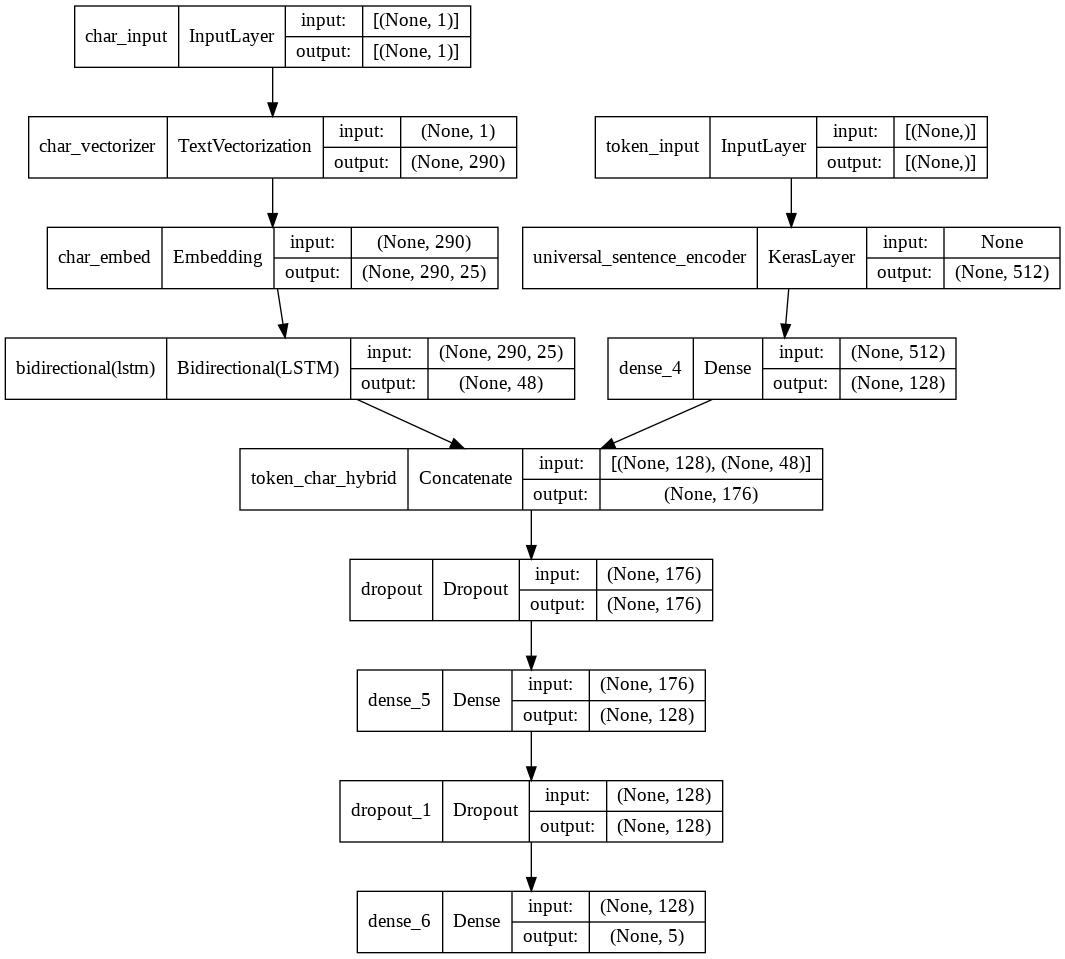

In [82]:
tf.keras.utils.plot_model(model_4, "model_4_token_char_embeddings.png", show_shapes=True)

In [83]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])

In [84]:
# Combining token and char data into tf.data Dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# repeat for validation dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
# prefetch and batch valid data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [86]:
# Fitting the model on token and char level sequences
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 197s 335ms/step - loss: 0.9778 - accuracy: 0.6115 - val_loss: 0.7705 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 172s 306ms/step - loss: 0.7944 - accuracy: 0.6964 - val_loss: 0.7055 - val_accuracy: 0.7324
Epoch 3/3
562/562 [==============================] - 172s 306ms/step - loss: 0.7568 - accuracy: 0.7137 - val_loss: 0.6776 - val_accuracy: 0.7374


In [87]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 61s 65ms/step - loss: 0.6736 - accuracy: 0.7422


[0.6736018657684326, 0.7421885132789612]

In [88]:
# Make predictions using the token-char model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.3088552e-01, 3.5486603e-01, 3.5583721e-03, 2.0158868e-01,
        9.1013592e-03],
       [3.2742685e-01, 4.7893748e-01, 3.8542710e-03, 1.8667062e-01,
        3.1108130e-03],
       [2.9820833e-01, 1.5490726e-01, 3.5018139e-02, 4.7501665e-01,
        3.6849648e-02],
       ...,
       [2.3913279e-04, 2.2872887e-03, 3.6958575e-02, 1.1502684e-04,
        9.6039999e-01],
       [7.5558261e-03, 8.5008070e-02, 3.0984852e-01, 3.3730650e-03,
        5.9421456e-01],
       [2.7691376e-01, 2.1596634e-01, 4.0755418e-01, 1.5184591e-02,
        8.4380992e-02]], dtype=float32)

In [89]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [90]:
# get the results of token char model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 74.21885343572092,
 'f1': 0.7387538526985851,
 'precision': 0.7420728495843,
 'recall': 0.7421885343572091}

In [91]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [92]:
# Create positional embeddings
# How mant line number are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

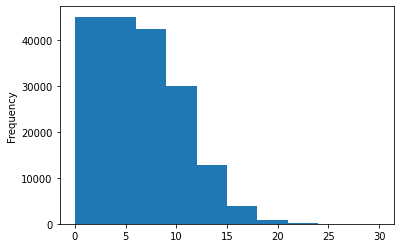

In [93]:
# Check distibution of line number column
train_df.line_number.plot.hist()

In [94]:
# Use tensorflow to crate one hot encoded tensors of line number
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15) # keep it at 15D to prevent the curse of dimensionality
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [95]:
# Encode total lines feature
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

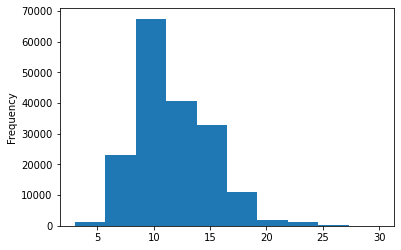

In [96]:
train_df.total_lines.plot.hist()

In [97]:
# check the coverage of a 'total lines' value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [98]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [99]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [100]:
train_total_lines_one_hot[0].shape

TensorShape([20])

In [101]:
# Building a tribrid embedding model

# Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)
# Total line inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name = 'total_line_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Combine tokens and char embeddings
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])

# Add dropout layers
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

#  Combine positional embedding with hybrid token and char embeddings
tribrid_embeddings = layers.Concatenate(name='tribrid_positional_char_token_embedding')([line_number_model.output,
                                                                                         total_line_model.output,
                                                                                         z])

# Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# Put together model with the kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer)

In [102]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

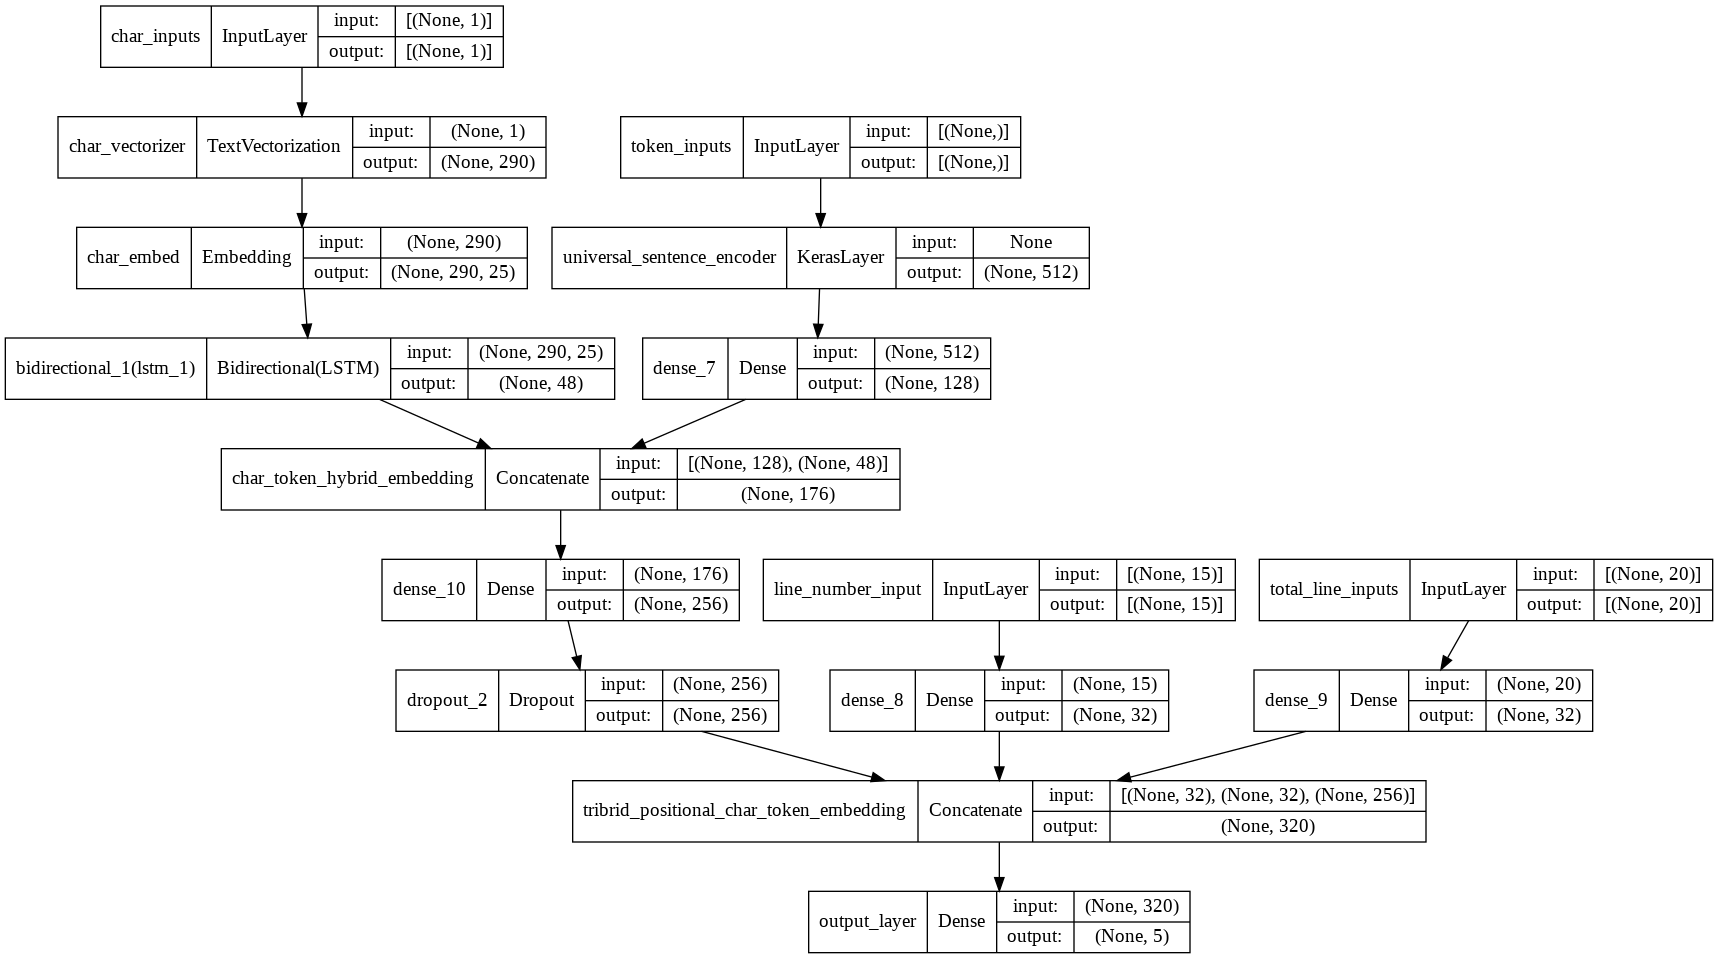

In [103]:
tf.keras.utils.plot_model(model_5, "model_5_tribrid.png", show_shapes=True)

In [104]:
# compile token char positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer='adam',
                metrics='accuracy')

In [105]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [106]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 200s 338ms/step - loss: 1.0829 - accuracy: 0.7354 - val_loss: 0.9816 - val_accuracy: 0.7952
Epoch 2/3
562/562 [==============================] - 179s 319ms/step - loss: 0.9615 - accuracy: 0.8196 - val_loss: 0.9465 - val_accuracy: 0.8288
Epoch 3/3
562/562 [==============================] - 179s 318ms/step - loss: 0.9439 - accuracy: 0.8282 - val_loss: 0.9360 - val_accuracy: 0.8358


In [107]:
# Make some predictions with the tribrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 89s 90ms/step


array([[0.52684075, 0.11318849, 0.00844225, 0.33651996, 0.01500848],
       [0.5692683 , 0.09224327, 0.02610366, 0.30497533, 0.00740948],
       [0.3091913 , 0.11616164, 0.08931471, 0.4338331 , 0.05149927],
       ...,
       [0.03574211, 0.07957911, 0.03195568, 0.03299732, 0.81972575],
       [0.03310659, 0.34895346, 0.08848789, 0.02552151, 0.5039305 ],
       [0.2537413 , 0.47674486, 0.13675538, 0.04787697, 0.08488148]],
      dtype=float32)

In [108]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [109]:
# Calcaulate results of tribrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)

model_5_results

{'accuracy': 83.77796901893288,
 'f1': 0.8368650049591503,
 'precision': 0.8374075177398372,
 'recall': 0.8377796901893287}

In [110]:
model_4_results

{'accuracy': 74.21885343572092,
 'f1': 0.7387538526985851,
 'precision': 0.7420728495843,
 'recall': 0.7421885343572091}

In [111]:
# Compare model results
# Combine model results into dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.435721,0.781251,0.784357,0.782096
model_2_pretrained_token_embedding,71.127367,0.711788,0.711274,0.708338
model_3_custom_char_embedding,69.028863,0.689553,0.690289,0.679532
model_4_hybrid_char_token_embedding,74.218853,0.742073,0.742189,0.738754
model_5_pos_char_token_embedding,83.777969,0.837408,0.837780,0.836865


In [112]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

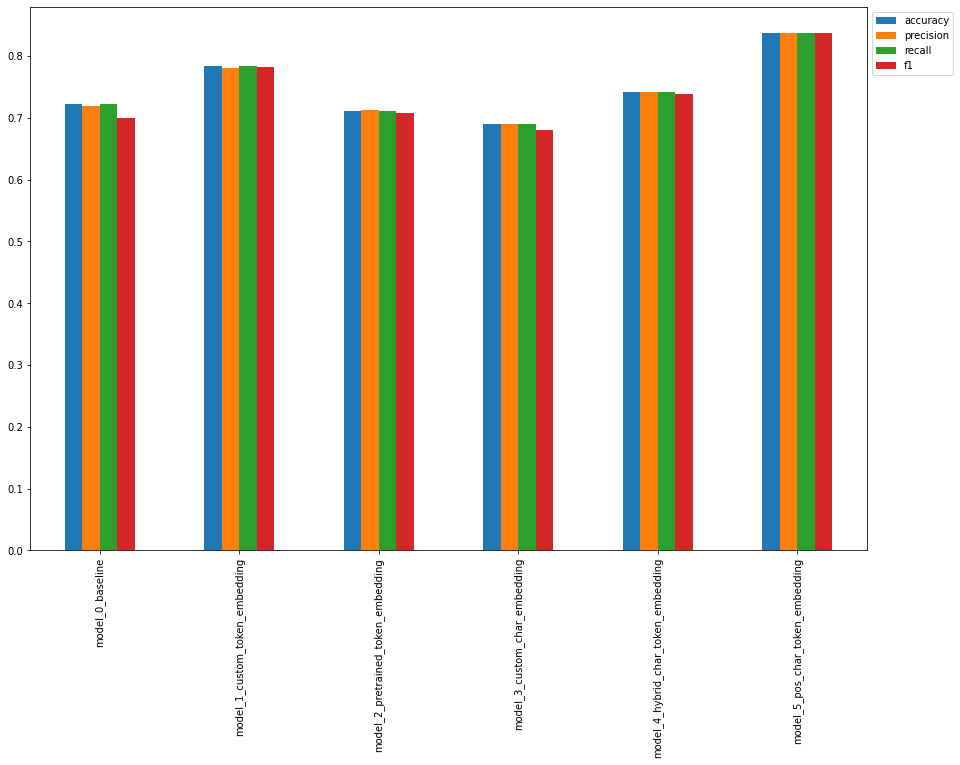

In [113]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(15,10)).legend(bbox_to_anchor=(1.0, 1.0));

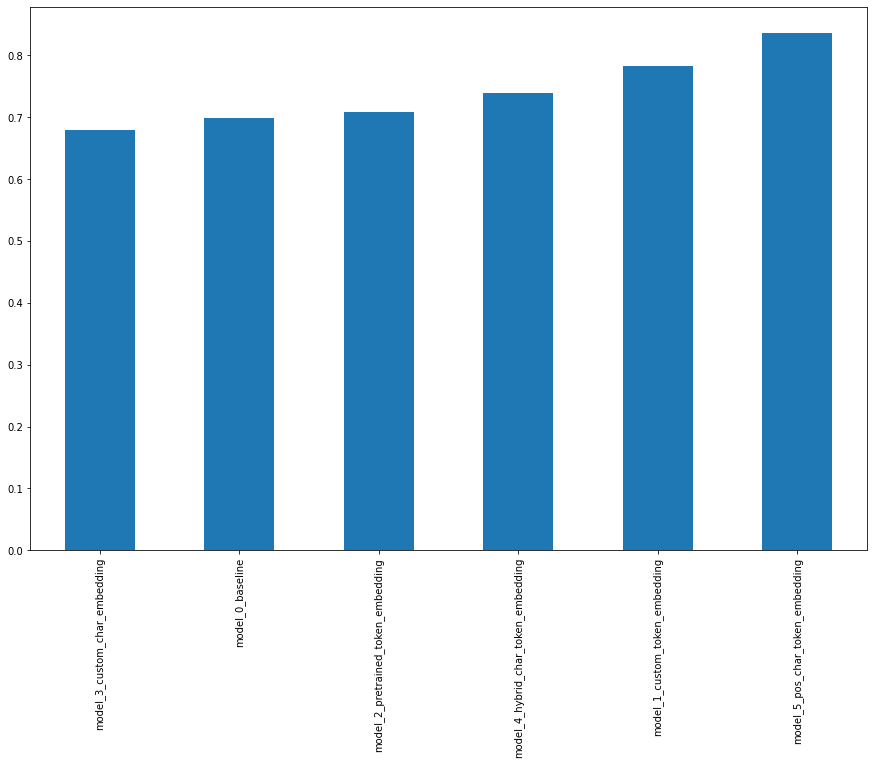

In [114]:
# Sort the model by f1 score
all_model_results.sort_values("f1", ascending=True)['f1'].plot(kind='bar', figsize=(15,10))

In [119]:
# Save and load model
model_5.save('model_5_tribrid_model')

INFO:tensorflow:Assets written to: model_5_tribrid_model/assets


INFO:tensorflow:Assets written to: model_5_tribrid_model/assets


In [120]:
# Load in best model
loaded_model = tf.keras.models.load_model('model_5_tribrid_model')

ValueError: ignored

In [ ]:
# Make predictions with loaded model on the validation dataset
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
# Calculate loaded model results
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results